## SETUP AND LIBRARIES

In [631]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import random
import os
import copy

In [669]:
# Ore data from the image
ore_data_list = [
    (15, 130848), (17, 128592), (19, 157920), (21, 180480), (23, 254928), (25, 275232),
    (27, 348160), (29, 564000), (31, 789600), (33, 726432), (35, 815200), (37, 880960),
    (39, 858800), (41, 820400), (43, 757280), (45, 630848), (47, 557920), (49, 380480),
    (51, 210880), (53, 238400), (55, 104560), (57, 106080), (59, 82000)
]

# Create a dictionary for ore data (grade: tonnage)
ore_data = {grade: ton for grade, ton in ore_data_list}

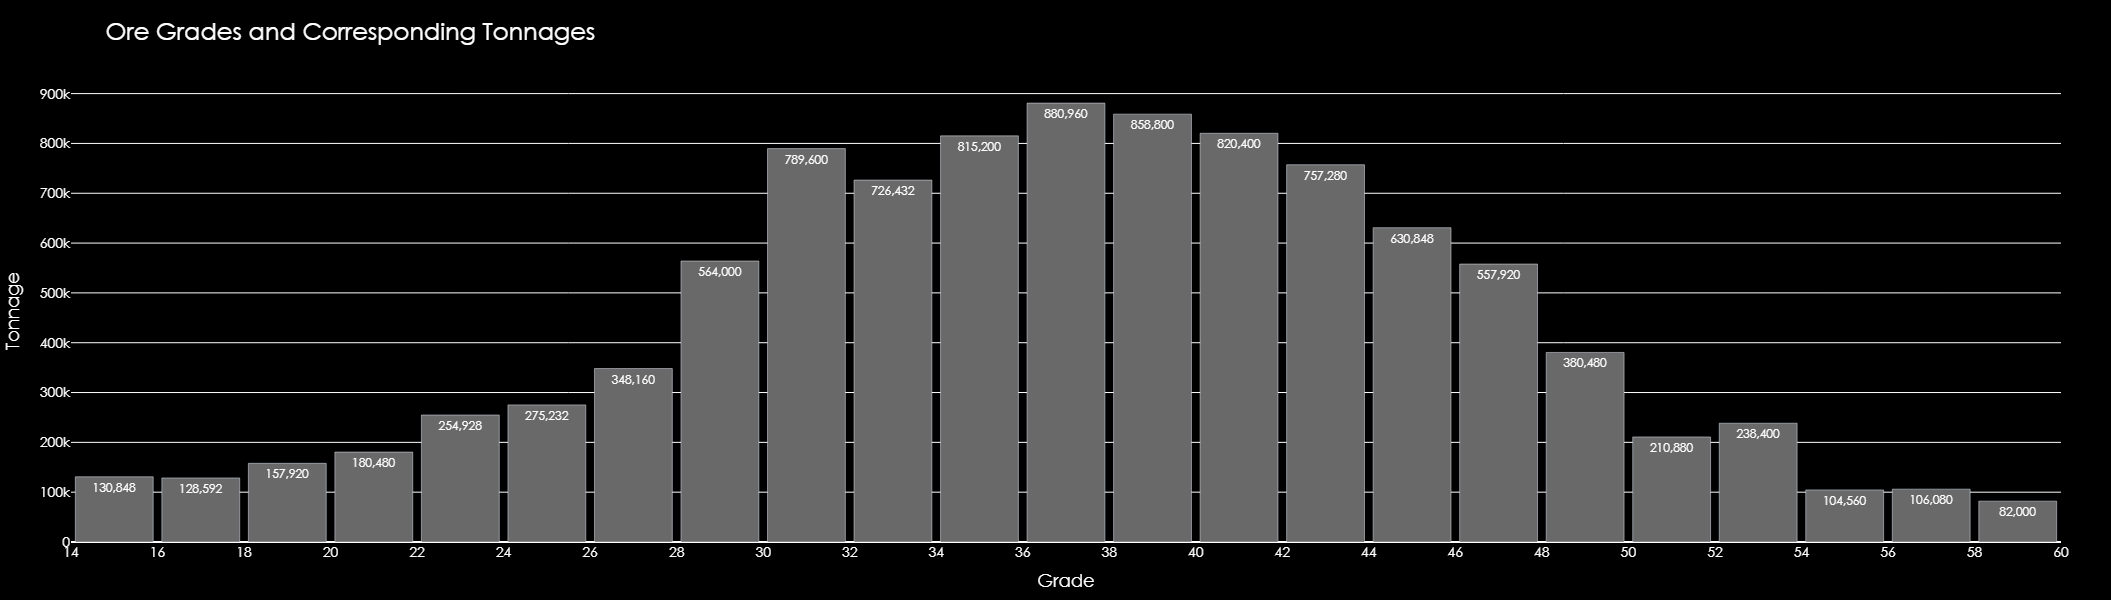

In [673]:
# Split data into two lists
grades, tonnages = zip(*ore_data_list)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=grades,
    y=tonnages,
    marker_color='dimgray',
    text=[f'{ton:,}' for ton in tonnages],
    textposition='auto',
    textfont=dict(
        family="Century Gothic, Bold",
        size=12,
        color='white'),))

fig.update_layout(
    title='Ore Grades and Corresponding Tonnages',
    xaxis_title='Grade',
    yaxis_title='Tonnage',
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(family="Century Gothic, Bold", color="white", size=14),
    title_font=dict(size=24, family='Century Gothic, Bold', color='white'),
    xaxis=dict(
        titlefont=dict(size=18, family='Century Gothic, Bold', color='white'),
        tickfont=dict(size=14, family='Century Gothic, Bold', color='white'),
        dtick=2),
    yaxis=dict(
        titlefont=dict(size=18, family='Century Gothic, Bold', color='white'),
        tickfont=dict(size=14, family='Century Gothic, Bold', color='white')),
    showlegend=False,
    margin=dict(l=50, r=50, t=80, b=50),
    bargap=0.1,
    height=600,
    width=1000)
fig.show()

In [635]:
# Get annual production tonnage from the user with error handling
while True:
    try:
        initial_annual_production_ton = int(input("Enter annual production tonnage (500,000 - 2,000,000): "))
        if not 500000 <= initial_annual_production_ton <= 2000000:
            raise ValueError("Production tonnage must be between 500,000 and 2,000,000.")
        break
    except ValueError as e:
        print(f"Invalid input: {e}")

Enter annual production tonnage (500,000 - 2,000,000):  1200000


## ANNUAL ORE GRADE TO BE PRODUCED
---

In [655]:
# Initial total tonnage
total_ton = sum(ore_data.values())

# Define production years
years_of_production = total_ton // initial_annual_production_ton
last_year_production_ton = total_ton % initial_annual_production_ton

# Create a list to store the results
results = []

def random_selection(ore_data, required_ton):
    selected_ores = []
    remaining_ton = required_ton

    while remaining_ton > 0 and ore_data:
        possible_grades = [grade for grade in ore_data if ore_data[grade] > 0]
        if not possible_grades:
            break
        grade = random.choice(possible_grades)
        ore_ton = ore_data[grade]
        tonnage_to_use = min(remaining_ton, ore_ton)

        if tonnage_to_use > 0:
            selected_ores.append((grade, tonnage_to_use))
            remaining_ton -= tonnage_to_use
            ore_data[grade] -= tonnage_to_use
            if ore_data[grade] == 0:
                del ore_data[grade]

    return selected_ores

def calculate_average_grade(selected_ores):
    total_ton = sum(ton for grade, ton in selected_ores)
    weighted_sum = sum(grade * ton for grade, ton in selected_ores)
    return weighted_sum / total_ton if total_ton else 0

remaining_ore_data = copy.deepcopy(ore_data)
grade_usage = {grade: [] for grade in ore_data.keys()}

for year in range(1, years_of_production + 2):
    if year == years_of_production + 1 and last_year_production_ton != 0:
        annual_production_ton = last_year_production_ton
    else:
        annual_production_ton = initial_annual_production_ton

    selected_ores = random_selection(remaining_ore_data, annual_production_ton)
    average_grade = calculate_average_grade(selected_ores)
    if selected_ores:
        results.append((year, annual_production_ton, round(average_grade, 1), selected_ores))

    for grade, ton in selected_ores:
        if grade in grade_usage:
            grade_usage[grade].append((year, ton))

df_results = pd.DataFrame(results, columns=["Year", "Annual Production (ton)", "Average Grade %", "Selected Ores"])
df_results['Annual Production (ton)'] = df_results['Annual Production (ton)'].apply(lambda x: "{:,}".format(x).replace(",", "."))
pd.set_option('display.max_colwidth', None)
df_results

,Year,Annual Production (ton),Average Grade %,Selected Ores
0,1,1.200.000,37.1,"[(17, 128592), (55, 104560), (35, 815200), (53, 151648)]"
1,2,1.200.000,34.3,"[(25, 275232), (23, 254928), (15, 130848), (57, 106080), (49, 380480), (33, 52432)]"
2,3,1.200.000,36.4,"[(41, 820400), (27, 348160), (19, 31440)]"
3,4,1.200.000,44.1,"[(45, 630848), (43, 569152)]"
4,5,1.200.000,32.1,"[(33, 674000), (31, 526000)]"
5,6,1.200.000,36.0,"[(31, 263600), (37, 880960), (43, 55440)]"
6,7,1.200.000,38.8,"[(51, 210880), (21, 180480), (43, 132688), (39, 675952)]"
7,8,1.200.000,41.6,"[(19, 126480), (53, 86752), (47, 557920), (59, 82000), (39, 182848), (29, 164000)]"
8,9,400.000,29.0,"[(29, 400000)]"


## PRODUCT QUANTITY
---

In [656]:
def calculate_yield(grade):
    return (-0.0004 * (grade ** 3)) + (0.0461 * (grade ** 2)) - (0.1765 * grade) + 0.72

def calculate_product(annual_ton, average_grade):
    yield_value = calculate_yield(average_grade) / 100  # Yield değeri zaten yüzde olarak hesaplanıyor
    product = annual_ton * yield_value
    return product

def calculate_cost(grade):
    return 0.1 * grade + 3.7

def calculate_mining_cost(annual_production):
    return (((-0.1 * (annual_production/100000)) + 8.5) * annual_production)

product_results = []

for year, annual_production_ton, average_grade, selected_ores in results:
    yield_value = calculate_yield(average_grade) / 100
    product = calculate_product(annual_production_ton, average_grade)
    p_cost = calculate_cost(average_grade) * product
    mining_cost = calculate_mining_cost(annual_production_ton)
    product_results.append((year, annual_production_ton, round(average_grade, 1), round(yield_value * 100, 1), int(product), int(p_cost), int(mining_cost)))

df_product_results = pd.DataFrame(product_results, columns=["Year", "Annual Production (ton)", "Average Grade %", "Yield (%)", "Product Quantity (ton)", "Processing Cost", "Mining Cost"])

df_product_results["Annual Production (ton)"] = df_product_results["Annual Production (ton)"].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_product_results["Product Quantity (ton)"] = df_product_results["Product Quantity (ton)"].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_product_results["Processing Cost"] = df_product_results["Processing Cost"].apply(lambda x: "${:,}".format(x).replace(",", "."))
df_product_results["Mining Cost"] = df_product_results["Mining Cost"].apply(lambda x: "${:,}".format(x).replace(",", "."))

total_waste_rock_cost = 15000000  # USD
number_of_years = df_product_results.shape[0]
waste_rock_cost_per_year = total_waste_rock_cost / number_of_years

df_product_results["Waste Rock Cost"] = waste_rock_cost_per_year
df_product_results["Waste Rock Cost"] = df_product_results["Waste Rock Cost"].apply(lambda x: "${:,}".format(int(x)).replace(",", "."))

pd.set_option("display.max_colwidth", None)
df_product_results

,Year,Annual Production (ton),Average Grade %,Yield (%),Product Quantity (ton),Processing Cost,Mining Cost,Waste Rock Cost
0,1,1.200.000,37.1,37.2,446.381,$3.307.684,$8.760.000,$1.666.666
1,2,1.200.000,34.3,32.8,393.129,$2.803.013,$8.760.000,$1.666.666
2,3,1.200.000,36.4,36.1,433.015,$3.178.334,$8.760.000,$1.666.666
3,4,1.200.000,44.1,48.3,579.427,$4.699.158,$8.760.000,$1.666.666
4,5,1.200.000,32.1,29.3,351.909,$2.431.694,$8.760.000,$1.666.666
5,6,1.200.000,36.0,35.4,425.390,$3.105.349,$8.760.000,$1.666.666
6,7,1.200.000,38.8,39.9,478.897,$3.630.045,$8.760.000,$1.666.666
7,8,1.200.000,41.6,44.4,532.318,$4.184.025,$8.760.000,$1.666.666
8,9,400.000,29.0,24.6,98.463,$649.862,$3.240.000,$1.666.666


## REVENUE
---

In [657]:
ore_prices = [70, 75, 82, 88, 96, 112, 125, 120, 118, 115, 120, 92, 110, 88, 115, 100, 110, 92, 90, 118]

def calculate_revenue(product_amounts, ore_prices):
    revenue_results = []
    total_revenue = 0
    for i, (year, annual_production_ton, avg_grade, yield_percentage, product_amount, _, _) in enumerate(product_amounts):
        price = ore_prices[i % len(ore_prices)]
        revenue = product_amount * price
        total_revenue += revenue
        revenue_results.append((year, round(avg_grade, 1), round(yield_percentage, 1), int(product_amount), int(revenue)))
    return revenue_results, total_revenue

revenue_results, total_revenue = calculate_revenue(product_results, ore_prices)

df_revenue_results = pd.DataFrame(revenue_results, columns=["Year", "Average Grade %", "Yield (%)", "Product Quantity (ton)", "Revenue (USD)"])

df_revenue_results['Product Quantity (ton)'] = df_revenue_results['Product Quantity (ton)'].apply(lambda x: "{:,}".format(x).replace(",", "."))
df_revenue_results['Revenue (USD)'] = df_revenue_results['Revenue (USD)'].apply(lambda x: "{:,}".format(x).replace(",", "."))
pd.set_option('display.max_colwidth', None)
df_revenue_results

,Year,Average Grade %,Yield (%),Product Quantity (ton),Revenue (USD)
0,1,37.1,37.2,446.381,31.246.670
1,2,34.3,32.8,393.129,29.484.675
2,3,36.4,36.1,433.015,35.507.230
3,4,44.1,48.3,579.427,50.989.576
4,5,32.1,29.3,351.909,33.783.264
5,6,36.0,35.4,425.390,47.643.680
6,7,38.8,39.9,478.897,59.862.125
7,8,41.6,44.4,532.318,63.878.160
8,9,29.0,24.6,98.463,11.618.634


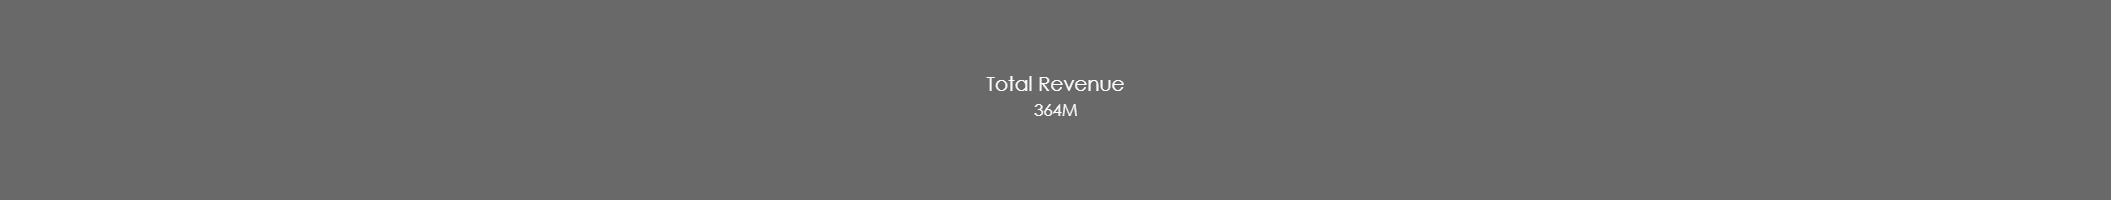

In [658]:
tr_fig = go.Figure()
tr_fig.add_trace(go.Indicator(mode="number", value=total_revenue, title={"text": "Total Revenue"}))
tr_fig.update_layout(
    height=200,
    width=1000,
    paper_bgcolor="dimgray",
    plot_bgcolor="black",
    font=dict(family="Century Gothic, Bold", color="white", size=20)
)
tr_fig.show()

## INVESTMENT AMOUNT FOR BENEFICIATION PLANT
---

In [660]:
def calculate_new_investment_cost(existing_cost, existing_capacity, factor=0.6):
    new_cost = existing_cost * (initial_annual_production_ton / existing_capacity) ** factor
    return new_cost
    """
    Calculate the new investment cost using the six-tenths factor rule.
    
    :param existing_cost: Existing investment cost (C1)
    :param existing_capacity: Existing capacity (Q1)
    :param new_capacity: New capacity (Q2)
    :param factor: Six-tenths factor (default is 0.6)
    :return: New investment cost (C2)
    """
existing_investment_cost = 10000000  # Existing investment cost (USD)
existing_capacity = 500000  # Existing capacity
new_investment_cost = calculate_new_investment_cost(existing_investment_cost, existing_capacity)

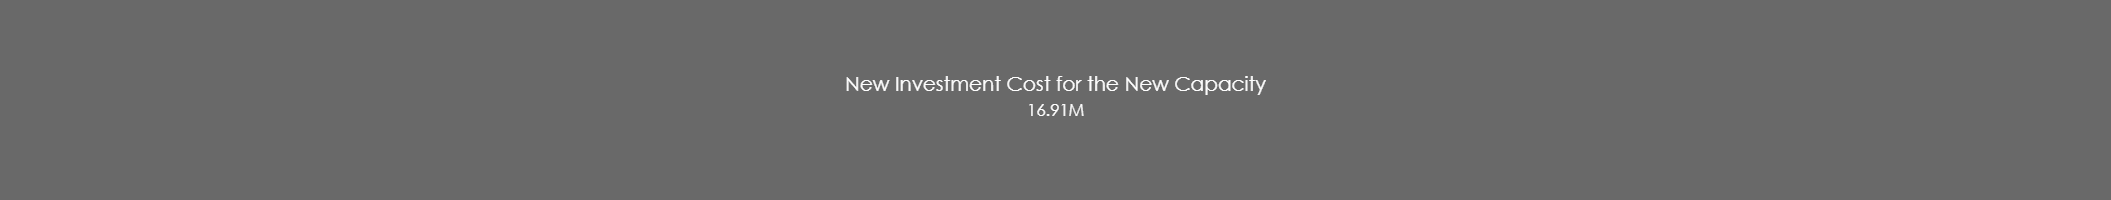

In [661]:
invest_fig = go.Figure()
invest_fig.add_trace(go.Indicator(mode="number", value=new_investment_cost, title={"text": "New Investment Cost for the New Capacity"}))
invest_fig.update_layout(
    height=200,
    width=1000,
    paper_bgcolor="dimgray",
    plot_bgcolor="black",
    font=dict(family="Century Gothic, Bold", color="white", size=20)
)
invest_fig.show()

## PLANT LOAN REPAYMENT AMOUNTS
---

In [662]:
def calculate_annual_payment(principal, annual_interest_rate, years):
    r = annual_interest_rate / 100
    n = years
    annual_payment = (principal * r) / (1 - (1 + r) ** -n)
    return annual_payment

principal = new_investment_cost  # new investment cost
annual_interest_rate = 5  # Annual interest rate (%)
years = 4  # Loan term (years)
annual_payment = calculate_annual_payment(new_investment_cost, annual_interest_rate, years)

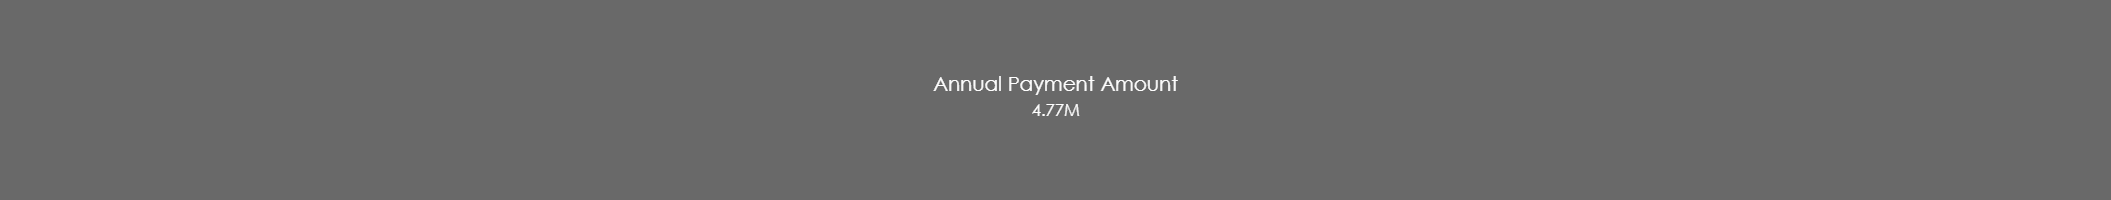

In [663]:
ap_fig = go.Figure()
ap_fig.add_trace(go.Indicator(mode="number", value=annual_payment, title={"text": "Annual Payment Amount"}))
ap_fig.update_layout(
    height=200,
    width=1000,
    paper_bgcolor="dimgray",
    plot_bgcolor="black",
    font=dict(family="Century Gothic, Bold", color="white", size=20)
)
ap_fig.show()

## NET INCOME
---

In [664]:
# Clean and convert 'Revenue (USD)' to float
df_net_income_results['Revenue (USD)'] = df_net_income_results['Revenue (USD)'].astype(str).apply(lambda x: x.replace('.', '').replace(',', '.')).astype(float)

# Other columns conversion
processing_costs = df_product_results['Processing Cost'].str.replace('$', '').str.replace('.', '').str.replace(',', '.').astype(float).tolist()
mining_costs = df_product_results['Mining Cost'].str.replace('$', '').str.replace('.', '').str.replace(',', '.').astype(float).tolist()
waste_rock_costs = df_product_results['Waste Rock Cost'].str.replace('$', '').str.replace('.', '').str.replace(',', '.').astype(float).tolist()

# Calculate net income
net_income_results = []
for i, (year, avg_grade, yield_percentage, product_amount, revenue) in enumerate(revenue_results):
    net_income = revenue - annual_payment - processing_costs[i] - mining_costs[i] - waste_rock_costs[i] if i < 4 else revenue - processing_costs[i] - mining_costs[i] - waste_rock_costs[i]
    net_income_results.append((
        year, avg_grade, yield_percentage, product_amount, revenue,
        int(annual_payment) if i < 4 else 0,
        int(processing_costs[i]), int(mining_costs[i]), int(waste_rock_costs[i]), 
        int(net_income)
    ))

df_net_income_results = pd.DataFrame(net_income_results, columns=[
    "Year", "Average Grade %", "Yield (%)", "Product Quantity (ton)", "Revenue (USD)", 
    "Annual Payment", "Processing Cost", "Mining Cost", "Waste Rock Cost", "Net Income (USD)"
])

# Formatting with apply and format function
df_net_income_results['Product Quantity (ton)'] = df_net_income_results['Product Quantity (ton)'].apply(lambda x: "{:,}".format(int(x)).replace(",", "."))
df_net_income_results['Revenue (USD)'] = df_net_income_results['Revenue (USD)'].apply(lambda x: "{:,}".format(int(x)).replace(",", "."))
df_net_income_results['Annual Payment'] = df_net_income_results['Annual Payment'].apply(lambda x: "{:,}".format(int(x)).replace(",", "."))
df_net_income_results['Processing Cost'] = df_net_income_results['Processing Cost'].apply(lambda x: "{:,}".format(int(x)).replace(",", "."))
df_net_income_results['Mining Cost'] = df_net_income_results['Mining Cost'].apply(lambda x: "{:,}".format(int(x)).replace(",", "."))
df_net_income_results['Waste Rock Cost'] = df_net_income_results['Waste Rock Cost'].apply(lambda x: "{:,}".format(int(x)).replace(",", "."))
df_net_income_results['Net Income (USD)'] = df_net_income_results['Net Income (USD)'].apply(lambda x: "{:,}".format(int(x)).replace(",", "."))

# Calculate total net income (no need for string conversion)
total_net_income = df_net_income_results['Net Income (USD)'].str.replace('.', '').str.replace(',', '.').astype(float).sum()
pd.set_option('display.max_colwidth', None)
df_net_income_results

,Year,Average Grade %,Yield (%),Product Quantity (ton),Revenue (USD),Annual Payment,Processing Cost,Mining Cost,Waste Rock Cost,Net Income (USD)
0,1,37.1,37.2,446.381,31.246.670,4.768.634,3.307.684,8.760.000,1.666.666,12.743.685
1,2,34.3,32.8,393.129,29.484.675,4.768.634,2.803.013,8.760.000,1.666.666,11.486.361
2,3,36.4,36.1,433.015,35.507.230,4.768.634,3.178.334,8.760.000,1.666.666,17.133.595
3,4,44.1,48.3,579.427,50.989.576,4.768.634,4.699.158,8.760.000,1.666.666,31.095.117
4,5,32.1,29.3,351.909,33.783.264,0,2.431.694,8.760.000,1.666.666,20.924.904
5,6,36.0,35.4,425.390,47.643.680,0,3.105.349,8.760.000,1.666.666,34.111.665
6,7,38.8,39.9,478.897,59.862.125,0,3.630.045,8.760.000,1.666.666,45.805.414
7,8,41.6,44.4,532.318,63.878.160,0,4.184.025,8.760.000,1.666.666,49.267.469
8,9,29.0,24.6,98.463,11.618.634,0,649.862,3.240.000,1.666.666,6.062.106


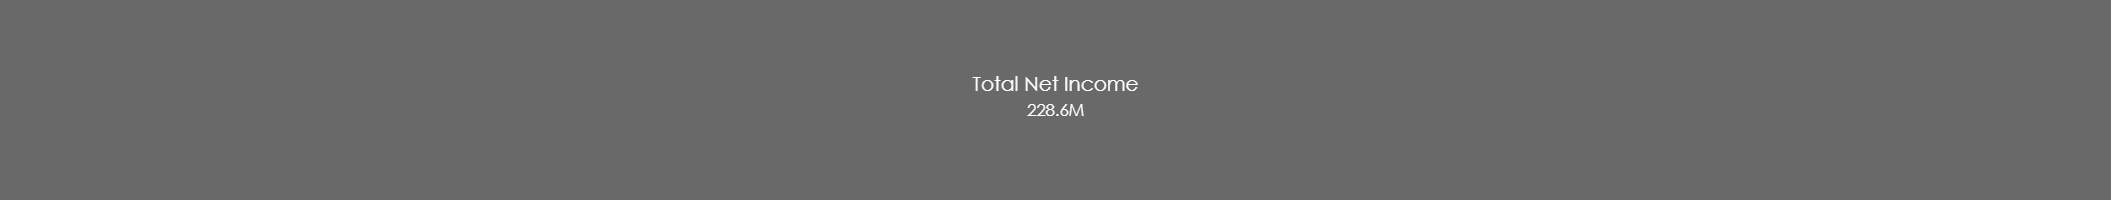

In [665]:
tni_fig = go.Figure()
tni_fig.add_trace(go.Indicator(mode="number",value=total_net_income,title={"text": "Total Net Income"},))
tni_fig.update_layout(
    height=200,
    width=1000,
    paper_bgcolor="dimgray",
    plot_bgcolor="black",
    font=dict(family="Century Gothic, Bold", color="white", size=20)
)
tni_fig.show()

## NET PRESENT VALUE
---

In [666]:
npv = 0
discount_rate = 0.1  # Define your discount rate here

for i in range(len(df_net_income_results)):
    discounted_net_income = float(df_net_income_results["Net Income (USD)"][i].replace('.', ''))
    npv += discounted_net_income / (1 + discount_rate) ** (i + 1)

net_present_value = npv - new_investment_cost

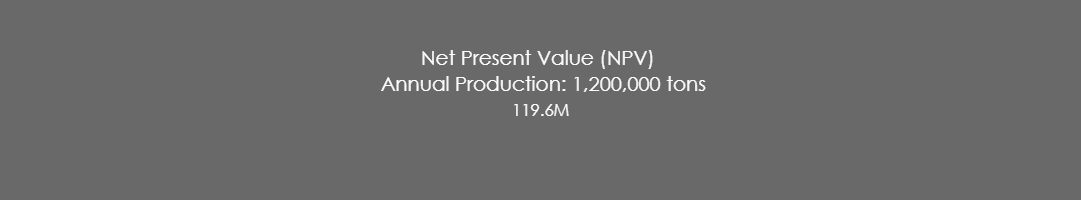

In [668]:
npv_fig = go.Figure()
npv_fig.add_trace(go.Indicator(
    mode="number",
    value=net_present_value,
    title={"text": f"Net Present Value (NPV) <br> Annual Production: {initial_annual_production_ton:,} tons"},))
npv_fig.update_layout(
    height=200,
    width=1000,
    paper_bgcolor="dimgray",
    plot_bgcolor="black",
    font=dict(family="Century Gothic, Bold", color="white", size=20)
)
npv_fig.show()